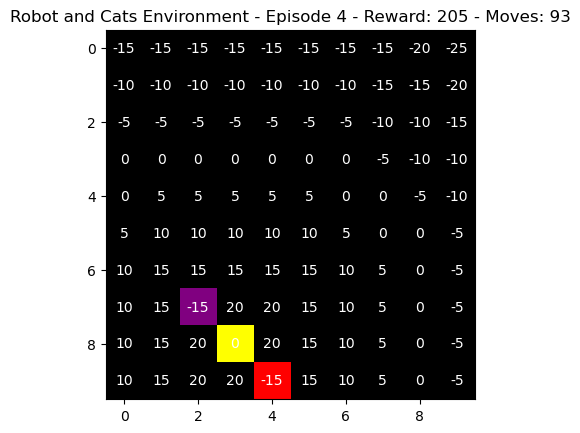

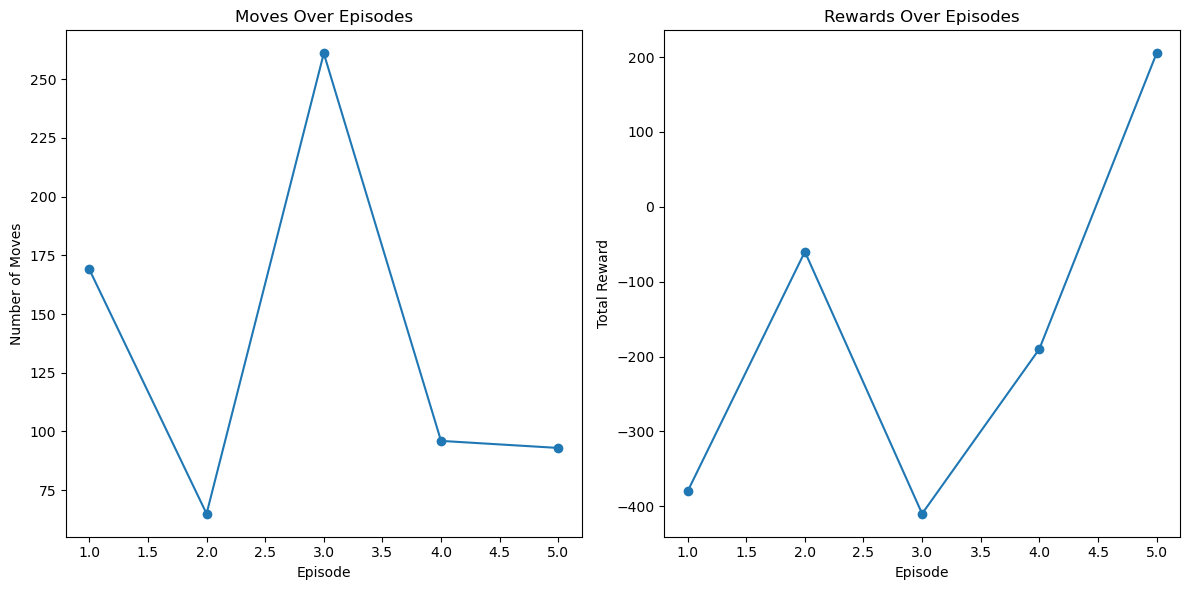

In [7]:
import gym
from gym import spaces
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output

class ModifiedQLearningAgent:
    def __init__(self, env, learning_rate=0.5, discount_factor=0.9, exploration_prob=1.0, exploration_decay=0.995):
        self.env = env
        self.learning_rate = learning_rate
        self.discount_factor = discount_factor
        self.exploration_prob = exploration_prob
        self.exploration_decay = exploration_decay
        self.q_table = np.zeros((env.box_size, env.box_size, env.action_space.n))
    
    def choose_action(self, state):
        if np.random.rand() < self.exploration_prob:
            return self.env.action_space.sample()  # Exploration: choose a random action
        else:
            state_indices = state[:, :, 0].clip(0, self.env.box_size - 1).reshape(-1)
            possible_actions = np.arange(self.env.action_space.n)
            values = self.q_table[state_indices[0], state_indices[1], possible_actions]
            values += np.random.normal(0, 0.1, len(possible_actions))
            action_probabilities = np.exp(2 * values / self.exploration_prob)
            action_probabilities /= np.sum(action_probabilities)
            chosen_action = np.random.choice(possible_actions, p=action_probabilities)
            return chosen_action

    def update_q_table(self, state, action, reward, next_state):
        state_indices = state[:, :, 0].clip(0, self.env.box_size - 1)
        next_state_indices = next_state[:, :, 0].clip(0, self.env.box_size - 1)
        best_next_action_value = np.max(self.q_table[next_state_indices[0], next_state_indices[1], :], axis=-1)
        current_q_value = self.q_table[state_indices[0], state_indices[1], action]
        updated_q_value = (1 - self.learning_rate) * current_q_value + \
                          self.learning_rate * (reward + self.discount_factor * best_next_action_value)
        self.q_table[state_indices[0], state_indices[1], action] = updated_q_value

    def decay_exploration_prob(self):
        self.exploration_prob *= self.exploration_decay
        self.exploration_prob = max(0.1, self.exploration_prob)

class RobotEnv(gym.Env):
    def __init__(self):
        super(RobotEnv, self).__init__()

        # Box size (changed to 10x10)
        self.box_size = 10

        # Number of possible actions (up, down, left, right)
        self.action_space = spaces.Discrete(4)

        # Observation space (environment state)
        self.observation_space = spaces.Box(low=0, high=255, shape=(self.box_size, self.box_size, 3), dtype=np.uint8)

        # Initial position of the robot
        self.robot_position = np.random.randint(self.box_size, size=2)

        # Initial positions of the cats
        self.cat1_position = self._generate_non_adjacent_position(self.box_size, self.robot_position)
        self.cat2_position = self._generate_non_adjacent_position(self.box_size, self.robot_position)

        # Initial state of the environment
        self.state = self._get_state()

    def _get_state(self):
        # Create a representation of the environment state (box with cats and robot)
        state = np.zeros((self.box_size, self.box_size, 3), dtype=np.uint8)

        # If it's the first step, don't draw the initial yellow square
        if not hasattr(self, 'initial_step') or not self.initial_step:
            state[:, :, 0] = 0
            self.initial_step = True

        # Adjust the midpoint to the closest valid grid position
        valid_midpoint = np.array([
            min(max(0, round(0.5 * (self.cat1_position[0] + self.cat2_position[0]))), self.box_size - 1),
            min(max(0, round(0.5 * (self.cat1_position[1] + self.cat2_position[1]))), self.box_size - 1)
        ])

        # Colors: yellow for the robot, purple for cat 1, red for cat 2
        state[self.cat1_position[0], self.cat1_position[1], :] = [128, 0, 128]  # Purple for cat 1
        state[self.cat2_position[0], self.cat2_position[1], :] = [255, 0, 0]  # Red for cat 2

        # Draw the midpoint as a green square
        state[valid_midpoint[0], valid_midpoint[1], :] = [0, 255, 0]  # Green for the midpoint

        return state

    def _generate_non_adjacent_position(self, box_size, avoid_position):
        # Generate a random position that is not adjacent to the avoided position
        position = np.random.randint(box_size, size=2)
        while np.abs(position - avoid_position).sum() == 1:  # Check non-adjacency
            position = np.random.randint(box_size, size=2)
        return position

    def step(self, action):
        # Execute the action and update the state
        if action == 0:  # up
            self.robot_position[0] = max(0, self.robot_position[0] - 1)
        elif action == 1:  # down
            self.robot_position[0] = min(self.box_size - 1, self.robot_position[0] + 1)
        elif action == 2:  # left
            self.robot_position[1] = max(0, self.robot_position[1] - 1)
        elif action == 3:  # right
            self.robot_position[1] = min(self.box_size - 1, self.robot_position[1] + 1)

        # Calculate the reward
        midpoint = 0.5 * (self.cat1_position + self.cat2_position)

        # Touching cats
        if (self.robot_position == self.cat1_position).all() or (self.robot_position == self.cat2_position).all():
            reward = -15
        else:
            # Calculate the distance to the midpoint
            distance_to_midpoint = np.linalg.norm(self.robot_position - midpoint)

            # Assign reward based on the distance to the midpoint
            reward = 25 - int(distance_to_midpoint) // 1 * 5

        # Penalize if the robot touches any cat
        if (self.robot_position == self.cat1_position).all() or (self.robot_position == self.cat2_position).all():
            reward -= 15  # Significant penalty for touching a cat

        # Check if the robot is on the midpoint
        done = (np.abs(self.robot_position - midpoint) <= 0.5).all()

        return self.state, reward, done, {}

    def reset(self):
        # Reset the environment to a random state
        self.robot_position = np.random.randint(self.box_size, size=2)
        self.cat1_position = self._generate_non_adjacent_position(self.box_size, self.robot_position)
        self.cat2_position = self._generate_non_adjacent_position(self.box_size, self.robot_position)
        self.state = self._get_state()
        return self.state
        
    def render(self, mode='human', close=False, episode_reward=None, episode_moves=None, episode_number=None):
        if mode == 'human':
            # Use clear_output to clear previous output
            clear_output(wait=True)

            # Create a copy of the image to not affect internal state
            image = np.copy(self.state)

            # Draw the midpoint as a green square
            midpoint = 0.5 * (self.cat1_position + self.cat2_position)
            midpoint = np.round(midpoint).astype(int)
            image[midpoint[0], midpoint[1], :] = [0, 255, 0]  # Green for the midpoint

            # Update the robot position in the image
            image[self.robot_position[0], self.robot_position[1], :] = [255, 255, 0]  # Yellow for the robot

            for i in range(self.box_size):
                for j in range(self.box_size):
                    # Get the reward value for each cell
                    cell_reward = self._get_cell_reward(np.array([i, j]), midpoint)

                    # Display the reward value in each box
                    plt.text(j, i, f'{cell_reward}', color='white', ha='center', va='center')

            plt.imshow(image)
            plt.title(f'Robot and Cats Environment - Episode {episode_number} - Reward: {episode_reward} - Moves: {episode_moves}')
            plt.show()
        elif mode == 'rgb_array':
            return self.state

    def _get_cell_reward(self, position, midpoint):
        # Calculate the reward for a specific cell
        if (position == self.robot_position).all():
            return 0  # Do not display reward at the robot position
        elif (position == self.cat1_position).all() or (position == self.cat2_position).all():
            return -15  # Penalty for touching a cat
        elif np.linalg.norm(position - midpoint) <= 0.5:
            return 25  # Reward for reaching the midpoint
        else:
            # Calculate the distance to the midpoint
            distance_to_midpoint = np.linalg.norm(position - midpoint)

            # Assign reward based on the distance to the midpoint
            return 25 - int(distance_to_midpoint) // 1 * 5

# Function to train the Q-learning agent
def train_q_learning_agent(env, agent, num_episodes=4):
    rewards = []
    moves = []

    for episode in range(1, num_episodes + 1):
        state = env.reset()
        total_reward = 0
        episode_moves = 0

        while True:
            action = agent.choose_action(state)
            next_state, reward, done, _ = env.step(action)

            agent.update_q_table(state, action, reward, next_state)

            total_reward += reward
            episode_moves += 1

            # Render the environment with the total episode reward and the number of moves
            env.render(episode_reward=total_reward, episode_moves=episode_moves, episode_number=episode)

            if done:
                break

            state = next_state

        agent.decay_exploration_prob()

        rewards.append(total_reward)
        moves.append(episode_moves)

    return rewards, moves

# Function to train the Q-learning agent
def train_q_learning_agent(env, agent, num_episodes=3):
    rewards = []
    moves = []

    for episode in range(1, num_episodes + 1):
        state = env.reset()
        total_reward = 0
        episode_moves = 0

        while True:
            action = agent.choose_action(state)
            next_state, reward, done, _ = env.step(action)

            agent.update_q_table(state, action, reward, next_state)

            total_reward += reward
            episode_moves += 1

            env.render(episode_reward=total_reward, episode_moves=episode_moves, episode_number=episode)

            if done:
                break

            state = next_state

        agent.decay_exploration_prob()

        rewards.append(total_reward)
        moves.append(episode_moves)

    return rewards, moves

# Training the Q-learning agent
env = RobotEnv()
q_agent = ModifiedQLearningAgent(env, learning_rate=0.5)  # Adjusted learning rate
num_episodes = 5
episode_rewards, episode_moves = train_q_learning_agent(env, q_agent, num_episodes)

# Save the last frame of each episode
for episode in range(num_episodes):
    env.render(episode_reward=episode_rewards[episode], episode_moves=episode_moves[episode], episode_number=episode)

# Plot rewards and number of moves over episodes
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(range(1, num_episodes + 1), episode_moves, marker='o') 
plt.title('Moves Over Episodes')
plt.xlabel('Episode')
plt.ylabel('Number of Moves')

plt.subplot(1, 2, 2)
plt.plot(range(1, num_episodes + 1), episode_rewards, marker='o')
plt.title('Rewards Over Episodes')
plt.xlabel('Episode')
plt.ylabel('Total Reward')

plt.tight_layout()
plt.show()